# Emulating HEC-WAT Tutorial

### This jupyter notebook steps through the training and validation of emulators for three of the HEC-WAT submodels: HEC-HMS, HEC-ResSim, and HEC-RAS.   

<div>
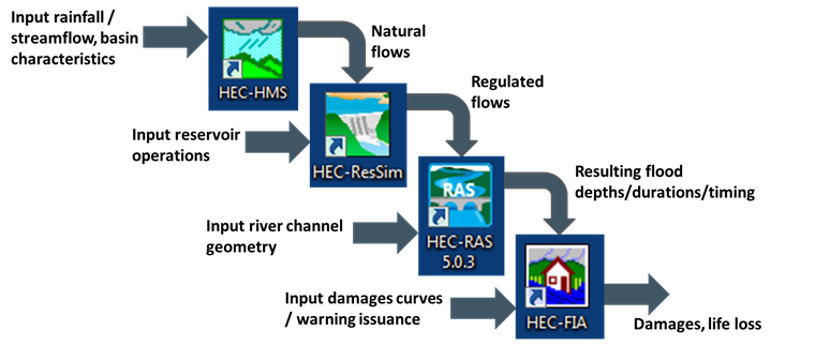
</div>


HEC-WAT is a framework that allows individual pieces of software to work together. These set of software are listed below:<br> 
1) HEC-HMS (Hydrologic) is a standalone software application that is designed to simulate the precipitation-runoff processes of dendritic watershed systems. HEC-HMS is a hydrologic precipitation rainfall-runoff model that generally provides simulated flow at multiple locations in the watershed. <br>
2)HEC-ResSim (Reservoirs) is a standalone software that is used to model reservoir operations at one or more reservoirs whose rule-based operations are defined by a variety of operational goals and constraints. The software simulates reservoir operations for flood management, low flow augmentation, and water supply for planning studies, detailed reservoir regulation plan investigations, and real time decision support. HEC-ResSim in the HEC-WAT compute sequence is a reservoir simulation model that provides regular flow hydrographs. <br>
3)HEC-RAS (Hydraulics) is a standalone software application that allows the user to perform one-dimensional steady and unsteady flow and two-dimensional unsteady flows. Also includes sediment transport/mobile bed computations, and water temperature modeling. There is also a Mapper tool that calculates the inundation boundary and water depth maps. HEC-RAS is a river hydraulic model that computes river stages, water surface profiles, and levee breach information and is used to compute consequences by HEC-FIA. <br>
4)HEC-FIA(Consequences) is a standalone software application that evaluates consequences using either continuously observed or simulated state hydrographs (hydrograph-based) or depth grids(GIS-based). For a specified analysis, the software evaluates urban and agricultural flood damage, area inundated, number of structures, and consequences. <br>
The figure above shows how the software are connected through the HEC-WAT framework and how model inputs and output feed into the standalone software. 

## Tuolumne River Basin

<div>
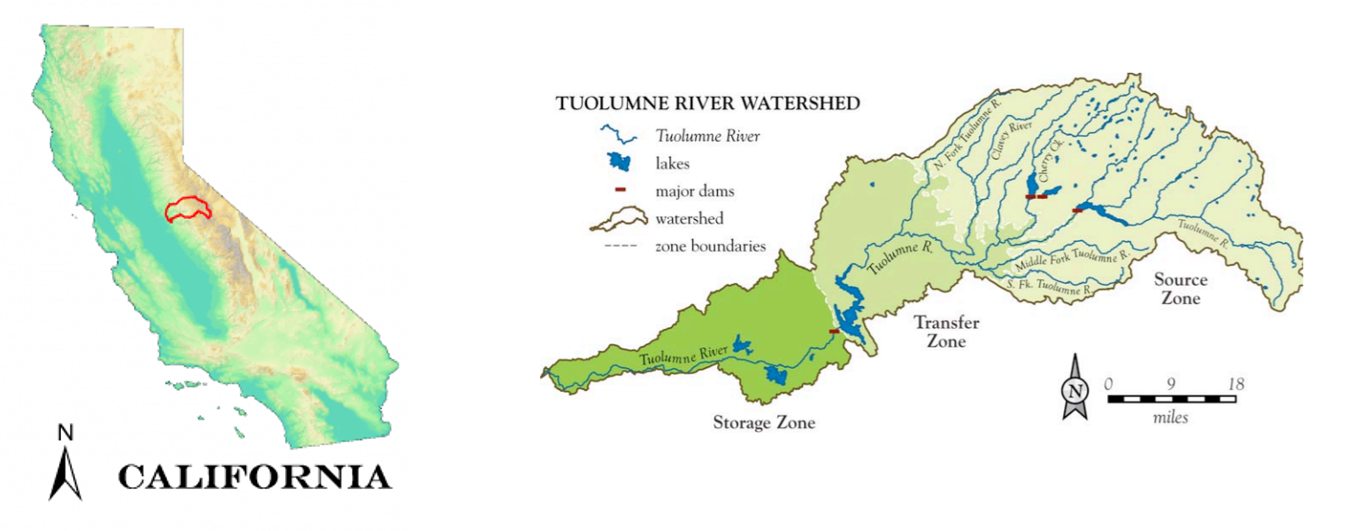
</div>

The area of focus for this project is the Tuolumne River Basin, located in Central California and approximately 1600 square miles. The basin starts in the Sierra Nevada mountain range at over 13,000 ft and ends 50 ft above sea level where it joins the San Joaquin River in the Central Valley. The Tuolumne and California in general exhibit incredibly complex interannual hydrology. Furthermore, the topology of the basin is such that some subbasins never receive snow, some receive snow for parts of the year, and some subbasins at the highest elevations have snow all year round. This makes emulation notably difficult. 

## HEC-HMS (Rainfall-Runoff)

HEC-HMS is the first submodel of the process. It takes in temperature and precipitation and predicts unregulated flow. The emulator chosen for HMS is a Long Short-Term Memory (LSTM) model, a form of a recurrent neural network that is particularly adept at remembering long sequences of informational. The LSTM contains a memory cell that continually evolves during the training period and decides which information to keep and forget through training. The intent with the implementation of the LSTM is to capture snow dynamics, given that snow is not an input that is provided to the model. Furthermore, the presence of snow and the general nature of the rainfall-runoff system leads to significant inertia in the system. Thus, we decide to utilize a model that is suitable to handle memory in the system. Below are the steps to implement a LSTM that is trained on an example subbasin. In the corresponding report, results are shown for three representative subbasins. In the original study, separate LSTMS are fit for seasonality. However, in this example, a single LSTM is demonstrated, utilizing the popular machine learning libraries: Keras and Tensorflow.

In [1]:
#Start virtual environment
!virtualenv --python C:\Users\Rohini\Anaconda3\pkgs\python-3.7.3-h8c8aaf0_0\python.exe venv
!.\venv\Scripts\activate    

created virtual environment CPython3.7.3.final.0-64 in 8994ms

  creator CPython3Windows(dest=C:\Users\Rohini\Desktop\HEC_WAT_Emulation\venv, clear=False, global=False)

  seeder FromAppData(download=False, pip=latest, setuptools=latest, wheel=latest, via=copy, app_data_dir=C:\Users\Rohini\AppData\Local\pypa\virtualenv\seed-app-data\v1.0.1)

  activators BashActivator,BatchActivator,FishActivator,PowerShellActivator,PythonActivator,XonshActivator


In [3]:
#install packages from requirements.txt file
! pip3 install -r requirements.txt

  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.0
    Uninstalling numpy-1.19.0:
      Successfully uninstalled numpy-1.19.0


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\rohini\\anaconda3\\lib\\site-packages\\~-mpy\\.libs\\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [4]:
#Importing necessary python libraries
import os
import pandas as pd
import tqdm
from tqdm import tqdm_notebook #This just visualizes the green progress bar that you see during training
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential,load_model #Building a sequential Keras model that is a linear stack of layers 
from keras.layers import LSTM, Dense
from keras.layers import Dropout, Activation, Flatten
from keras.optimizers import SGD

Using TensorFlow backend.
C:\Users\Rohini\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Rohini\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Rohini\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Rohini\Anaconda3\lib\site-packages\tensorflow\python\framework\dtype

In [5]:
#Load in the input data and view
os.getcwd()
os.chdir("./HMS/Training_Testing")
df_ge = pd.read_csv("Sub_0.csv", index_col=0) 
print(df_ge.head())

   X      Dates  Year  Month  Day  Hours  Precipitation  Temperature  Outflow  \
1  1  10/1/1980  1980     10    1   0.00            0.0      102.992        5   
2  2  10/1/1980  1980     10    1   0.04            0.0       97.790        5   
3  3  10/1/1980  1980     10    1   0.08            0.0       92.588        5   
4  4  10/1/1980  1980     10    1   0.13            0.0       87.404        5   
5  5  10/1/1980  1980     10    1   0.17            0.0       85.172        5   

    sin_day  Three_Day_Flow  Two_Week_Flow  Month_Flow  Season_Flow  \
1  0.841471             0.0            0.0         0.0          0.0   
2  0.841471             0.0            0.0         0.0          0.0   
3  0.841471             0.0            0.0         0.0          0.0   
4  0.841471             0.0            0.0         0.0          0.0   
5  0.841471             0.0            0.0         0.0          0.0   

   Precip_Times_Temperature  Temperature_Times_Day  \
1                       0.0     

In [6]:
#Check for null values. The presence of NAs will interfere with the training
print("checking if any null values are present\n", df_ge.isna().sum()) 

checking if any null values are present
 X                                      0
Dates                                  0
Year                                   0
Month                                  0
Day                                    0
Hours                                 21
Precipitation                          0
Temperature                            0
Outflow                                0
sin_day                                0
Three_Day_Flow                         0
Two_Week_Flow                          0
Month_Flow                             0
Season_Flow                            0
Precip_Times_Temperature               0
Temperature_Times_Day                  0
Precip_Times_Temperature_Times_Day     0
cos_day                                0
dtype: int64


In [7]:
#Specify the training columns by their names
train_cols = ["Precipitation","Temperature","sin_day","cos_day","Month","Three_Day_Flow","Two_Week_Flow", "Month_Flow", "Season_Flow","Precip_Times_Temperature","Temperature_Times_Day","Precip_Times_Temperature_Times_Day"]
label_cols = ["Outflow"]

#Specify the number of lagged hours that you are interested in 
TIME_STEPS = 18

#Specify the training and testing size
df_train, df_test = train_test_split(df_ge, train_size=0.6, test_size=0.4, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))

Train and Test size 111326 74218


In [8]:
# Loading training data and labels into x_train and y_train respectively
x = df_train.loc[:,train_cols].values
y = df_train.loc[:,label_cols].values
x_train=x
y_train=y
#Load testing data and labels into x_test and y_test
x_test = df_test.loc[:,train_cols].values
y_test = df_test.loc[:,label_cols].values
print(x_test)

[[  0.          63.878        0.42016704 ...   0.          26.83942998
    0.        ]
 [  0.          67.172        0.42016704 ...   0.          28.2234602
    0.        ]
 [  0.          71.276        0.42016704 ...   0.          29.94782572
    0.        ]
 ...
 [  0.          57.074       -0.98803162 ...   0.         -56.39091691
    0.        ]
 [  0.          57.056       -0.98803162 ...   0.         -56.37313234
    0.        ]
 [  0.          57.02        -0.98803162 ...   0.         -56.33756321
    0.        ]]


In [9]:
# This function normalizes the input data
def Normalization_Transform(x):
    x_mean=np.mean(x, axis=0)
    x_std= np.std(x, axis=0)
    xn = (x-x_mean)/x_std
    return xn, x_mean,x_std

In [10]:
# This function reverses the normalization 
def inverse_Normalization_Transform(xn, x_mean,x_std):
    xd = (xn*x_std)+x_mean
    return xd

In [11]:
#This function creates the time series of input data that will feed into the LSTM. Every time step you will feed in a matrix
#of inputs that is (length of time step)x(number of input variables). For example, if you're using a lag of 18 hours for only precip
#and temperature, but you just want the present values for the other variables, you will have a matrix that is 18x12, where 12 is the 
#number of input variables. The first two columns will be completely populated with the previous 18 hours of values, but the rest of the columns will only have the
#first row populated and the rest of the rows are zero. 

# If you open this jupyter notebook in Spyder, it's much easier to visualize what's going on here. 
def build_timeseries(mat, y_label,y_label_Actual, TIME_STEPS):
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    y_Actual = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] =y_label[TIME_STEPS+i, 0]
        y_Actual[i] =y_label_Actual[TIME_STEPS+i, 0]
        x[i,1:,2:]=0
    print("length of time-series i/o",x.shape,y.shape)
    return x, y, y_Actual

In [12]:
#This block of code just uses the above-defined functions to normalize and build the time series of data

# Normalizing Data Training Data
x_train_Nor , x_mean_train, x_std_train = Normalization_Transform(x_train)
y_train_Nor , y_mean_train, y_std_train = Normalization_Transform(y_train)

# Converting the data into timeseries 
X_Train, Y_Train, Y_Train_Actual = build_timeseries(x_train_Nor, y_train_Nor,y_train,TIME_STEPS)

# Normalizing Validation  Data
x_test_Nor , x_mean_test, x_std_test = Normalization_Transform(x_test)
y_test_Nor , y_mean_test, y_std_test = Normalization_Transform(y_test)

# Converting the data into timeseries 
X_Val, Y_Val,Y_Val_Actual = build_timeseries(x_test_Nor,y_test_Nor, y_test, TIME_STEPS)

#Check that the inputs are correctly portrayed 
print(X_Train)


length of time-series i/o (111308, 18, 12) (111308,)



length of time-series i/o (74200, 18, 12) (74200,)
[[[-0.1430454   2.52715736  1.17047483 ... -0.14363053  1.83340497
    0.01402785]
  [-0.1430454   2.18941586  0.         ...  0.          0.
    0.        ]
  [-0.1430454   1.85167435  0.         ...  0.          0.
    0.        ]
  ...
  [-0.1430454   0.61874255  0.         ...  0.          0.
    0.        ]
  [-0.1430454   1.03244668  0.         ...  0.          0.
    0.        ]
  [-0.1430454   1.44498216  0.         ...  0.          0.
    0.        ]]

 [[-0.1430454   2.18941586  1.17047483 ... -0.14363053  1.74040175
    0.01402785]
  [-0.1430454   1.85167435  0.         ...  0.          0.
    0.        ]
  [-0.1430454   1.5151015   0.         ...  0.          0.
    0.        ]
  ...
  [-0.1430454   1.03244668  0.         ...  0.          0.
    0.        ]
  [-0.1430454   1.44498216  0.         ...  0.          0.
    0.        ]
  [-0.1430454   1.85868629  0.         ...  0.          0.
    0.        ]]

 [[-0.1430454   

In [13]:
print(X_Val)
print(Y_Val)

[[[-0.112414   -0.0860765   0.58081988 ... -0.11139117  0.55166658
    0.01038851]
  [-0.112414    0.13041922  0.         ...  0.          0.
    0.        ]
  [-0.112414    0.40015159  0.         ...  0.          0.
    0.        ]
  ...
  [-0.112414    0.57169191  0.         ...  0.          0.
    0.        ]
  [-0.112414    0.33626761  0.         ...  0.          0.
    0.        ]
  [-0.112414    0.21796394  0.         ...  0.          0.
    0.        ]]

 [[-0.112414    0.13041922  0.58081988 ... -0.11139117  0.58058301
    0.01038851]
  [-0.112414    0.40015159  0.         ...  0.          0.
    0.        ]
  [-0.112414    0.66988396  0.         ...  0.          0.
    0.        ]
  ...
  [-0.112414    0.33626761  0.         ...  0.          0.
    0.        ]
  [-0.112414    0.21796394  0.         ...  0.          0.
    0.        ]
  [-0.112414    0.09966027  0.         ...  0.          0.
    0.        ]]

 [[-0.112414    0.40015159  0.58081988 ... -0.11139117  0.61661003
 

In [ ]:
# Initialize the LSTM as a sequential model, so we're just going to keep tacking on layers 
model = Sequential() 
# Adding the first LSTM layer and some dropout for regularization (to minimize overfitting)
#The first layer always needs to receive an input shape which is defined by the training data
#Adding return_sequences=True is necessary for stacking LSTM layers (if you have an LSTM layer after another LSTM layer)
model.add(LSTM(24, return_sequences=True,
               input_shape=(X_Train.shape[1], X_Train.shape[2])))  
model.add(Dropout(0.2))

# Adding a couple more LSTM layers and dropout regularization. The units (hidden states), the number of layers, and the dropout regularization
#term are all hyperparameters that you will want to optimize. The values here are just typical default values to start off with. 

model.add(LSTM(units = 50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

#Usually you need to just implement a dense layer to serve as the output layer, but I added an additional layer here 
#because I got better results

model.add(Dense(20,activation='relu')) #RELU is a more common activation function now rather than sigmoidal. 


#This last dense layer is just the output layer, which has a linear activation function because you're essentially
#just returning the results from the last layer. 

model.add(Dense(1, activation="linear"))



#This line is where you compile the final model. We are using the adam (default) gradient descent based optimizer
#The choice of loss function is based on your understanding of the inherent noise in the data. 
#You can also implement a custom loss function. 
#I also implemented an accuracy metrics but in the context of regression it doesn't mean anything (only in classification). 

model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['accuracy']) 

# The batch size and number of epochs are also hyperparameters that can be tuned. 
#Generally, you will want to have a large number of epochs, but over you'll probaby see only marginal benefits
#The batch size can kind've have a large implication on how the LSTM trains. Batches can maybe act as a 
#proxy to train for seasonality. Typical batch sizes are closer to 24, 48, 64, but I found that larger batch sizes 
#might find some seasonality
history=model.fit(X_Train, Y_Train,
          batch_size=365, epochs=15,
          validation_data=(X_Val, Y_Val))
# Model summary for number of parameters use in the algorithm 
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 111308 samples, validate on 74200 samples
Epoch 1/15


 69350/111308 [=================>............] - ETA: 37:56 - loss: 1.3436 - acc: 0.0000e+ - ETA: 19:25 - loss: 1.2685 - acc: 0.0000e+ - ETA: 13:12 - loss: 1.3176 - acc: 0.0000e+ - ETA: 10:05 - loss: 1.3223 - acc: 0.0000e+ - ETA: 8:12 - loss: 1.1841 - acc: 0.0000e+00 - ETA: 6:57 - loss: 1.0572 - acc: 0.0000e+0 - ETA: 6:09 - loss: 1.0208 - acc: 0.0000e+0 - ETA: 5:27 - loss: 0.9501 - acc: 0.0000e+0 - ETA: 4:53 - loss: 0.8848 - acc: 0.0000e+0 - ETA: 4:27 - loss: 0.8406 - acc: 0.0000e+0 - ETA: 4:05 - loss: 0.8519 - acc: 0.0000e+0 - ETA: 3:46 - loss: 0.8752 - acc: 0.0000e+0 - ETA: 3:30 - loss: 0.9057 - acc: 0.0000e+0 - ETA: 3:17 - loss: 0.9280 - acc: 0.0000e+0 - ETA: 3:12 - loss: 0.9339 - acc: 0.0000e+0 - ETA: 3:02 - loss: 0.8902 - acc: 0.0000e+0 - ETA: 2:54 - loss: 0.9188 - acc: 0.0000e+0 - ETA: 2:46 - loss: 0.8957 - acc: 0.0000e+0 - ETA: 2:38 - loss: 0.9083 - acc: 0.0000e+0 - ETA: 2:31 - loss: 0.8760 - acc: 0.0000e+0 - ETA: 2:25 - loss: 0.8753 - acc: 0.0000e+0 - ETA: 2:19 - loss: 0.8477 -

111308/111308 [==============================] - ETA: 22s - loss: 0.4692 - acc: 0.0000e+ - ETA: 22s - loss: 0.4673 - acc: 0.0000e+ - ETA: 22s - loss: 0.4660 - acc: 0.0000e+ - ETA: 22s - loss: 0.4643 - acc: 0.0000e+ - ETA: 21s - loss: 0.4639 - acc: 0.0000e+ - ETA: 21s - loss: 0.4667 - acc: 0.0000e+ - ETA: 21s - loss: 0.4652 - acc: 0.0000e+ - ETA: 21s - loss: 0.4655 - acc: 0.0000e+ - ETA: 20s - loss: 0.4648 - acc: 0.0000e+ - ETA: 20s - loss: 0.4636 - acc: 0.0000e+ - ETA: 20s - loss: 0.4624 - acc: 0.0000e+ - ETA: 20s - loss: 0.4623 - acc: 0.0000e+ - ETA: 19s - loss: 0.4608 - acc: 0.0000e+ - ETA: 19s - loss: 0.4618 - acc: 0.0000e+ - ETA: 19s - loss: 0.4619 - acc: 0.0000e+ - ETA: 19s - loss: 0.4603 - acc: 0.0000e+ - ETA: 19s - loss: 0.4596 - acc: 0.0000e+ - ETA: 18s - loss: 0.4584 - acc: 0.0000e+ - ETA: 18s - loss: 0.4569 - acc: 0.0000e+ - ETA: 18s - loss: 0.4558 - acc: 0.0000e+ - ETA: 18s - loss: 0.4551 - acc: 0.0000e+ - ETA: 17s - loss: 0.4535 - acc: 0.0000e+ - ETA: 17s - loss: 0.4518 - a

 51465/111308 [============>.................] - ETA: 32s - loss: 0.1287 - acc: 0.0000e+ - ETA: 34s - loss: 0.0975 - acc: 0.0000e+ - ETA: 33s - loss: 0.0949 - acc: 0.0000e+ - ETA: 34s - loss: 0.1165 - acc: 0.0000e+ - ETA: 33s - loss: 0.1291 - acc: 0.0000e+ - ETA: 33s - loss: 0.1552 - acc: 0.0000e+ - ETA: 32s - loss: 0.1700 - acc: 0.0000e+ - ETA: 31s - loss: 0.1641 - acc: 0.0000e+ - ETA: 30s - loss: 0.1759 - acc: 0.0000e+ - ETA: 30s - loss: 0.1846 - acc: 0.0000e+ - ETA: 29s - loss: 0.2451 - acc: 0.0000e+ - ETA: 29s - loss: 0.2558 - acc: 0.0000e+ - ETA: 29s - loss: 0.2427 - acc: 0.0000e+ - ETA: 28s - loss: 0.2566 - acc: 0.0000e+ - ETA: 28s - loss: 0.2658 - acc: 0.0000e+ - ETA: 28s - loss: 0.2657 - acc: 0.0000e+ - ETA: 28s - loss: 0.2650 - acc: 0.0000e+ - ETA: 27s - loss: 0.2714 - acc: 0.0000e+ - ETA: 27s - loss: 0.2646 - acc: 0.0000e+ - ETA: 27s - loss: 0.2568 - acc: 0.0000e+ - ETA: 27s - loss: 0.2615 - acc: 0.0000e+ - ETA: 27s - loss: 0.2550 - acc: 0.0000e+ - ETA: 28s - loss: 0.2547 - a

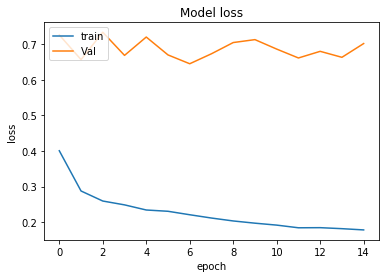

In [15]:
#Here, we plot some model diagnostics. We show how the loss value changes as a function of epoch. 
#As the LSTM sees more of the data, we expect the training loss to decrease. 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

In [16]:
#Quick check that the normalized values will be inverted back to the original scale. We predict just the first 100 values of the test set. 

x_buffer = np.zeros((1,X_Train.shape[1], X_Train.shape[2]))
for i in range(100):
    x_buffer[0,:,:] = X_Val[i,:,:]
    print(inverse_Normalization_Transform(model.predict( x_buffer), y_mean_train, y_std_train),Y_Val_Actual[i])

[[1.20144416]] 4.0
[[0.97784645]] 4.0
[[0.78000599]] 4.0
[[0.63651316]] 4.0
[[0.56713247]] 4.0
[[0.54654843]] 4.0
[[0.56244904]] 4.0
[[0.66151812]] 4.0
[[0.82965098]] 4.0
[[1.03684548]] 4.0
[[1.26418626]] 4.0
[[1.57424974]] 4.0
[[1.81980002]] 4.0
[[2.00026729]] 4.0
[[2.11345549]] 4.0
[[2.14972405]] 4.0
[[2.10665123]] 4.0
[[1.97776731]] 4.0
[[1.80382098]] 4.0
[[1.61337061]] 4.0
[[1.3844012]] 4.0
[[1.13008509]] 4.0
[[0.86024852]] 4.0
[[0.58401266]] 4.0
[[0.3544158]] 4.0
[[0.17997328]] 4.0
[[0.0624682]] 4.0
[[0.00371886]] 4.0
[[-0.00201138]] 4.0
[[0.04049802]] 4.0
[[0.13130788]] 4.0
[[0.27945213]] 4.0
[[0.48778628]] 4.0
[[0.73159669]] 4.0
[[0.87399789]] 4.0
[[1.14827139]] 4.0
[[1.42828234]] 4.0
[[1.66842571]] 4.0
[[1.8517693]] 4.0
[[1.95822848]] 4.0
[[1.98744468]] 4.0
[[1.93006388]] 4.0
[[1.83283711]] 4.0
[[1.70273831]] 4.0
[[1.5270377]] 4.0
[[1.31733341]] 4.0
[[1.08557171]] 4.0
[[0.84515143]] 4.0
[[0.64291246]] 4.0
[[0.48429692]] 4.0
[[0.37072297]] 4.0
[[0.31382715]] 4.0
[[0.30737983]] 4

In [37]:
#Prediction of validation data labels. You predict the normalize value and then invert it 
prediction =inverse_Normalization_Transform( model.predict(X_Val),y_mean_train, y_std_train)
prediction

array([[1.20144736],
       [0.97784965],
       [0.78000279],
       ...,
       [5.42719908],
       [5.52376639],
       [5.57882149]])

In [24]:
len(prediction)

74200

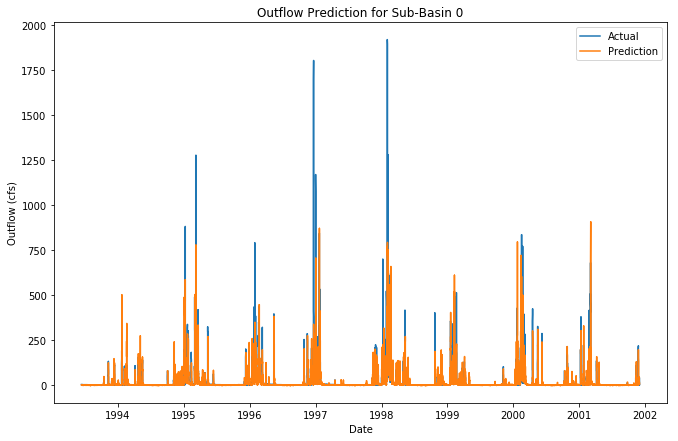

In [39]:
#Plot the prediction results and the validation results
#First figure out the index that testing starts. This will always be the training index+lag. The first [lagged value] values are not predicted
dates=df_ge.iloc[111344:185544, 1].values
import datetime as dt
x = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]
plt.figure(figsize=(11, 7))
plt.plot(x,Y_Val_Actual)
plt.plot(x,prediction)
plt.title('Outflow Prediction for Sub-Basin 0')
plt.ylabel('Outflow (cfs)')
plt.xlabel('Date')
plt.legend(['Actual','Prediction'], loc='upper right')

#plt.savefig("Sub_0_Prediction.jpg")
plt.show()


In [40]:
#RMSE value
np.sqrt(mean_squared_error(prediction, Y_Val_Actual))

56.46277288286433

In [111]:
#Save the Results
import numpy
os.chdir("../Predictions")
numpy.savetxt("Sub0_60_40_new.csv", np.c_[prediction,Y_Val_Actual], delimiter=",") #Currently have to do this manually
os.chdir("../")

Much like any emulator, achieving good performance across low flows and high flows is very difficult. The emulator especially has a lot of difficulty capturing the magnitude of extremes. However, we show that the emulator can capture most of the flow regime, denoted in the FDC.

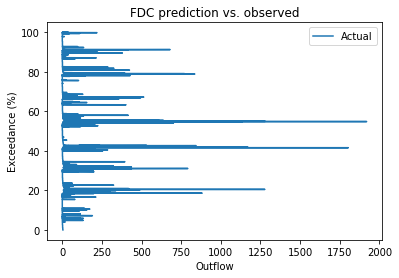

In [108]:
np.size(Y_Val_Actual)
ranked_data=-np.sort(-Y_Val_Actual)
ranking=np.linspace(1,np.size(Y_Val_Actual),np.size(Y_Val_Actual))
df_new=pd.DataFrame({'Discharge':ranked_data[:,0],'Ranking':ranking,'P':(ranking*100/np.size(Y_Val_Actual))})
plt.plot(df_new.iloc[:,0],df_new.iloc[:,2])

#np.size(y_pred)
#ranked_data=-np.sort(-y_pred)
#ranking=np.linspace(1,np.size(y_pred),np.size(y_pred))
#df_new=pd.DataFrame({'Discharge':ranked_data,'Ranking':ranking,'P':(ranking*100/np.size(y_test))})
#plt.plot(df_new.iloc[:,0],df_new.iloc[:,2])

plt.title('FDC prediction vs. observed')
plt.ylabel('Exceedance (%)')
plt.xlabel('Outflow')
plt.legend(['Actual','Prediction'], loc='upper right')

## HEC-ResSim (Reservoir Operations)

HEC-ResSim is the second submodel in the chain. It takes in the unregulated flow from HMS and predicts a regulated flow after reservoir operations are established. The emulator chosen for ResSim is Random Forests, which are an ensemble of decision trees. We shown the training of the ResSim emulator using Eleanor Lake as an example. In the corresponding report, results are shown for all four reservoirs. A different random forest model is fit for each reservoir. We also illustrate how to tune the hyperparameters of the model and use the tuned model for the prediction. 

In [81]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

In [82]:
#Import dataset and split into features and labels
dataset = pd.read_csv('../../ResSim/Training/eleanor_daily.csv')
X = dataset.iloc[:, 1:14].values
y = dataset.iloc[:, 14].values

In [83]:
#Check for null values
print("checking if any null values are present\n", dataset.isna().sum())

checking if any null values are present
 Date                         0
ELEANOR_IN                   0
month                        0
sin_doy                      0
cos_doy                      0
CHERRY_IN                    0
Previous_Day_Flow            0
Previous_Week_Flow           0
Previous_Day_Flow_CHERRY     0
Previous_Week_Flow_CHERRY    0
Temperature                  0
Precipitation                0
Previous_Day_Precip          0
Previous_Three_Day_Precip    0
ELEANOR_OUT                  0
ELEANOR_POOL                 0
dtype: int64


In [84]:
#Split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0, shuffle=False)


# Feature Scaling (normalize features)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(X_test.shape)


(4383, 13)


Implement a grid search to hypertune parameters. First, outline the parameters for random forests and create a grid. We will start with a random search that will help to narrow down the range of options. 

In [85]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [86]:
#Create a random forest model
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 2, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    8.1s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   17.9s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=2, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [88]:
#View the best parameters
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

In [90]:
#Evaluate the accuracy of prediction
y_pred = rf_random.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 44.47771385606103
Mean Squared Error: 8106.139326294472
Root Mean Squared Error: 90.03410090790307
R-Squared: 0.8268389908435203


In [91]:
#Calculate the Modified Nash Sutcliffe Efficiency
numerator=0
denominator=0
for i in range(len(y_pred)):
       numerator=numerator+abs((y_pred[i]-y_test[i]))
       denominator=denominator+abs((np.mean(y_test)-y_test[i]))
      
NSE=1-(numerator/denominator)       
print(NSE)

0.7223845765058023


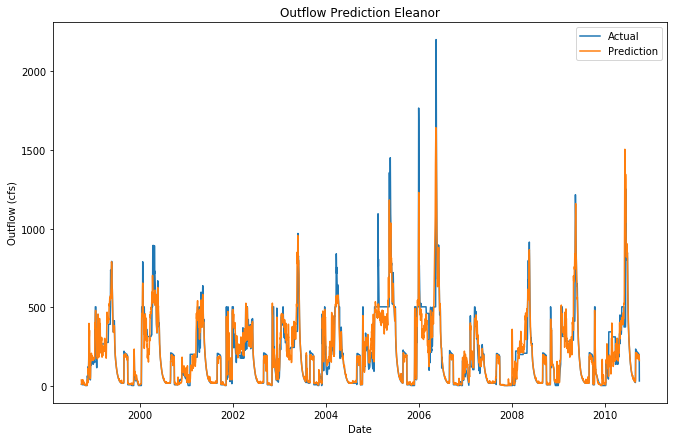

In [92]:
plt.figure(figsize=(11, 7))
#plt.plot(dataset.iloc[37108:61849, 14].values,y_test)
#plt.plot(dataset.iloc[37108:61849, 14].values,y_pred)
dates=dataset.iloc[6574:10957, 0].values
import datetime as dt
x = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]
ax = plt.gca()
#formatter = dates.DateFormatter("%Y-%m-%d")
#ax.xaxis.set_major_formatter(formatter)
#locator = dates.DayLocator()
#ax.xaxis.set_major_locator(locator)
plt.plot(x, y_test)
plt.plot(x, y_pred)
plt.title('Outflow Prediction Eleanor')
plt.ylabel('Outflow (cfs)')
plt.xlabel('Date')
plt.legend(['Actual','Prediction'], loc='upper right')
#np.savetxt("outflow_prediction.csv",np.c_[y_pred,y_test],delimiter=",")
#plt.savefig("eleanor_outflow.png")

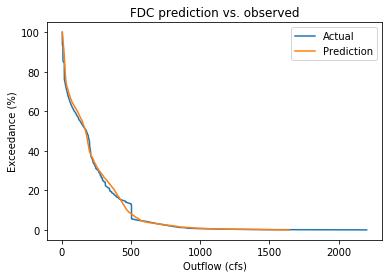

In [103]:
np.size(y_test)
ranked_data=-np.sort(-y_test)
ranking=np.linspace(1,np.size(y_test),np.size(y_test))
df_new=pd.DataFrame({'Discharge':ranked_data,'Ranking':ranking,'P':(ranking*100/np.size(y_test))})
plt.plot(df_new.iloc[:,0],df_new.iloc[:,2])

np.size(y_pred)
ranked_data=-np.sort(-y_pred)
ranking=np.linspace(1,np.size(y_pred),np.size(y_pred))
df_new=pd.DataFrame({'Discharge':ranked_data,'Ranking':ranking,'P':(ranking*100/np.size(y_test))})
plt.plot(df_new.iloc[:,0],df_new.iloc[:,2])

plt.title('FDC prediction vs. observed')
plt.ylabel('Exceedance (%)')
plt.xlabel('Outflow (cfs)')
plt.legend(['Actual','Prediction'], loc='upper right')

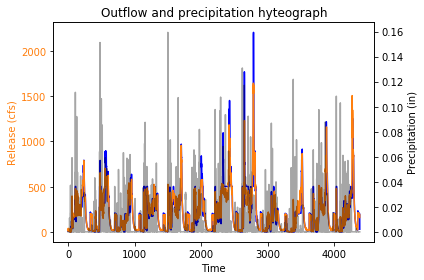

In [101]:
precip=dataset.iloc[6574:10957, 11].values
fig, ax1 = plt.subplots()

color = 'tab:orange'
ax1.set_xlabel('Time')
ax1.set_ylabel('Release (cfs)', color=color)
ax1.plot(y_test, color='b')
ax1.plot(y_pred, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

plt.title('Outflow and precipitation hyteograph')
ax2.set_ylabel('Precipitation (in)', color='black')  # we already handled the x-label with ax1
ax2.plot(precip, color='k',alpha=0.35)
ax2.tick_params(axis='y', labelcolor='black')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

We can also plot storage dynamics. The same code is used, just a different training set. 

In [118]:
#Import dataset and split into features and labels
#dataset = pd.read_csv('E:/ArmyCorp/ELEANOR_ML_FINAL.csv')
#X = dataset.iloc[:, 0:11].values
#y = dataset.iloc[:, 12].values #event pool
#y = dataset.iloc[:, 13].values # pool
dataset = pd.read_csv('../../ResSim/Training/eleanor_daily.csv')
X = dataset.iloc[:, 1:14].values
y = dataset.iloc[:, 15].values

#Split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0, shuffle=False)


# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(X_test.shape)


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)


#Create a random forest model
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 2, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

y_pred = rf_random.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))

(4383, 13)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    6.7s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   17.8s finished


Mean Absolute Error: 1770.8301218929005
Mean Squared Error: 12021702.859887386
Root Mean Squared Error: 3467.23273806178
R-Squared: 0.6875691228771877


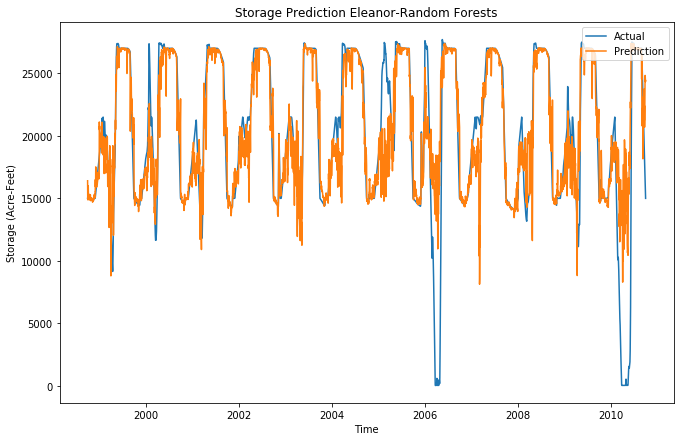

In [119]:
plt.figure(figsize=(11, 7))
#plt.plot(dataset.iloc[37108:61849, 14].values,y_test)
#plt.plot(dataset.iloc[37108:61849, 14].values,y_pred)
#dates=dataset.iloc[37108:61849, 15].values
#import datetime as dt
#x = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]
#ax = plt.gca()
import datetime as dt
dates=dataset.iloc[6574:10957, 0].values
x = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]
#formatter = dates.DateFormatter("%Y-%m-%d")
#ax.xaxis.set_major_formatter(formatter)
#locator = dates.DayLocator()
#ax.xaxis.set_major_locator(locator)
plt.plot(x, y_test)
plt.plot(x, y_pred)
plt.title('Storage Prediction Eleanor-Random Forests')
plt.ylabel('Storage (Acre-Feet)')
plt.xlabel('Time')
plt.legend(['Actual','Prediction'], loc='upper right')
#np.savetxt("storage_prediction.csv",np.c_[y_pred,y_test],delimiter=",")
#plt.savefig("eleanor_storage.png")

## HEC-RAS (Hydraulics)

HEC-RAS is the third submodel in the chain. It takes in the regulated flow at the end of the reservoir chain (downstream of Don Pedro) and then predicts flow and stage at various cross sections across Dry Creek and the Tuolumne River. The data for the emulation is this submodel is very limited because it is only run for flooding events. There are three flooding events that we train the model on and we use it to predict stage at the "Warning Cross Section". When the stage at this cross-section goes above 50 ft, the downstream residents are warned and notified to evacuate. As with ResSim, random forests are used for this model. The training set is composed of three flooding events (1997, 2011, 2017) that are appended together and thus are not continuous events.

In [109]:
#Import dataset and split into features and labels
#dataset = pd.read_csv('E:/ArmyCorp/ELEANOR_ML_FINAL.csv')
#X = dataset.iloc[:, 0:11].values
#y = dataset.iloc[:, 13].values
dataset = pd.read_csv('../../RAS/Training/Calibration_data.csv')
X = dataset.iloc[:, 2:4].values
y = dataset.iloc[:, 3].values

In [110]:
print("checking if any null values are present\n", dataset.isna().sum())

checking if any null values are present
 Date               0
Tuolumne_Flow      0
Dry_Creek_Flow     0
W_cross_section    0
Only_Date          0
Time               0
year               0
month              0
day                0
hour               0
dtype: int64


In [111]:
#Split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0, shuffle=False)


# Feature Scaling
sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_train = np.array(X_train).reshape(-1,1)
#X_test = np.array(X_test).reshape(-1,1)
X_train=sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(X_test.shape)

(4897, 2)


In [112]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [113]:
#Create a random forest model
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 2, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    5.8s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   10.9s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=2, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [114]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

In [115]:
y_pred = rf_random.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))


Mean Absolute Error: 1.491770734456171
Mean Squared Error: 5.989951495342179
Root Mean Squared Error: 2.447437740851068
R-Squared: 0.8050405865008089


In [116]:
#Calculate the Modified Nash Sutcliffe Efficiency
numerator=0
denominator=0
for i in range(len(y_pred)):
       numerator=numerator+abs((y_pred[i]-y_test[i]))
       denominator=denominator+abs((np.mean(y_test)-y_test[i]))
      
NSE=1-(numerator/denominator)       
print(NSE)

0.7125772589647488


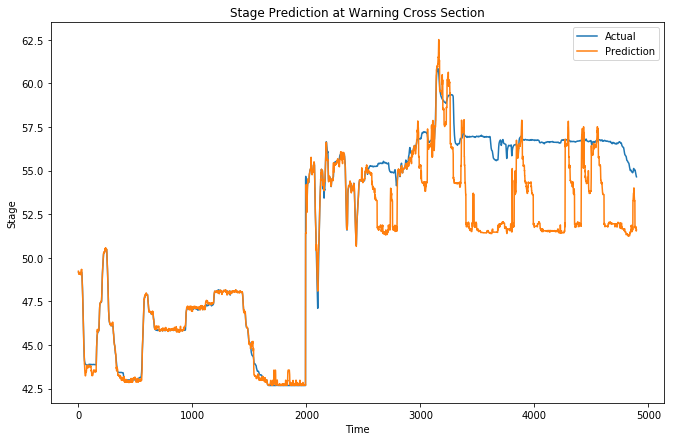

In [117]:
plt.figure(figsize=(11, 7))


#ax = plt.gca()
#formatter = dates.DateFormatter("%Y-%m-%d")
#ax.xaxis.set_major_formatter(formatter)
#locator = dates.DayLocator()
#ax.xaxis.set_major_locator(locator)
plt.plot(y_test)
plt.plot(y_pred)
plt.title('Stage Prediction at Warning Cross Section')
plt.ylabel('Stage')
plt.xlabel('Time')
plt.legend(['Actual','Prediction'], loc='upper right')
#np.savetxt("outflow_prediction.csv",np.c_[y_pred,y_test],delimiter=",")
#plt.savefig("Sub0_man.png")
#np.savetxt("Sub0_60_40_old.csv", np.c_[y_pred,y_test], delimiter=",") #Currently have to do this manually

The relationship between flow and stage is usually quite straightforward. However, for this cross-section, both flow in Dry Creek and the Tuolumne must be factored in. The first two events, 1997 and 2011 are similiar, and thus the algorithms has no problem predicting the last half of the 2011 event. However, the 2017 event correponds to a situation that has not been observed in the training data before: high stage and low flow at Dry Creek. This leads to an underprediction. With more data, that represents the possible combinations of flow at the two tributaries and stage, this bias can likely be fixed.  